# Data Setup

In [1]:
import kagglehub
import os
import numpy as np
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("fmena14/volcanoesvenus")

# Get the list of all files and directories 
files = os.listdir(path)
print(f"Files and directories in '{path}':\n{files}")  

train_files = os.listdir(os.path.join(path, 'Volcanoes_train'))
test_files = os.listdir(os.path.join(path, 'Volcanoes_test'))

# Check files inside the 'Volcanoes_test' and 'Volcanoes_train' files
print(f"Files in 'Volcanoes_train':\n{train_files}")
print(f"Files in 'Volcanoes_test':\n{test_files}")

# We use 'header=None' for 'X_train' and 'X_test' so pandas doesn't treat the first row as indeces
X_train = pd.read_csv(os.path.join(path, 'Volcanoes_train', 'train_images.csv'), header=None)
y_train = pd.read_csv(os.path.join(path, 'Volcanoes_train', 'train_labels.csv'))
X_test = pd.read_csv(os.path.join(path, 'Volcanoes_test', 'test_images.csv'), header=None)
y_test = pd.read_csv(os.path.join(path, 'Volcanoes_test', 'test_labels.csv'))

Files and directories in 'C:\Users\lotop\.cache\kagglehub\datasets\fmena14\volcanoesvenus\versions\1':
['Volcanoes_test', 'Volcanoes_train']
Files in 'Volcanoes_train':
['train_images.csv', 'train_labels.csv']
Files in 'Volcanoes_test':
['test_images.csv', 'test_labels.csv']


# Data Preprocessing

In [2]:
print(X_train.head())
print('-'*80)
print(y_train.head())
print('-'*80)
print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')
print('-'*80)
print(X_train.info())
print('-'*80)
print(y_train.info())

   0      1      2      3      4      5      6      7      8      9      ...  \
0     95    101     99    103     95     86     96     89     70    104  ...   
1     91     92     91     89     92     93     96    101    107    104  ...   
2     87     70     72     74     84     78     93    104    106    106  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4    114    118    124    119     95    118    105    116    123    112  ...   

   12090  12091  12092  12093  12094  12095  12096  12097  12098  12099  
0    111    107     92     89    103     99    117    116    118     96  
1    103     92     93     95     98    105    104    100     90     81  
2     84     71     95    102     94     80     91     80     84     90  
3     94     81     89     84     80     90     92     80     88     96  
4    116    113    102     93    109    104    106    117    111    115  

[5 rows x 12100 columns]
-------------------------------------------------

In this analysis, we are only interested in identifying the presence or absence of volcanoes. Therefore, the `Volcano?` column will be used as the target variable. Fortunately, it doesn't contain any NaN values. The NaN values in the other columns (`Type`, `Radius`, `Number Volcanoes`) are irrelevant for this task and can be safely ignored.

In [3]:
# Extract the 'Volcano?' column as the target variable
y_train = y_train['Volcano?']
y_test = y_test['Volcano?']

In this notebook, we will implement a **random forest** to evaluate the dataset at hand. Unlike gradient-based models, such as logistic regression, random forests are tree-based and thus not sensitive to feature scaling. This means that preprocessing steps like normalization are not necessary.

However, methods for dimensionality reduction (e.g., PCA) or oversampling (e.g., SMOTE) could still benefit the model by addressing issues such as noise or class imbalance. Not only, PCA could also help making the whole process less computationally expensive.

Given the initial high dimensionality of the dataset ($12 \, 100$ input features) and its unbalanced nature, we wil apply both PCA and SMOTE. Before applying PCA, we need to normalize the data. Before doing any of this, we still need to address the corrupted images present in the dataset.

## Corrupted images

In [4]:
def corruptedImages(data):
    corruptedImagesIndex = []
    for index, image in enumerate(np.resize(data, (data.shape[0], 12100))): # resize (7000, 110, 110, 1) to (7000,12100)
        sum = 0
        for pixelIndex in range(0,len(image)):
            sum += image[pixelIndex]
            if pixelIndex == 10:
                break
        if sum == 0:
            corruptedImagesIndex.append(index)
        else:
            sum = 0

    for index, image in enumerate(np.resize(data, (data.shape[0], 12100))): # resize (7000, 110, 110, 1) to (7000,12100)
        sum = 0
        for pixelIndex in range(0,len(image),110):
            sum += image[pixelIndex]
            if pixelIndex == 10:
                break
        if sum == 0 and index not in corruptedImagesIndex:
            corruptedImagesIndex.append(index)
        else:
            sum = 0
    return corruptedImagesIndex
 
print(str(len(corruptedImages(X_train)))+" corrupted images")

209 corrupted images


In [5]:
def deleteCorrupted(X, y, corruptedIndexList):
    for i in corruptedIndexList:
        X.drop(i, inplace=True) # Drop the corrupted
        y.drop(i, inplace=True) 
    
    X.reset_index(inplace=True) # Reconstruct the index
    X.drop(['index'], axis=1, inplace=True) # Delete old index column
    #Because they are pandas.series we don't need to deal with index
    #Because we use inplace=True we don't need to return something

In [6]:
trainCorruptedList = corruptedImages(X_train)
testCorruptedList = corruptedImages(X_test)

deleteCorrupted(X_train, y_train, trainCorruptedList)
deleteCorrupted(X_test, y_test, testCorruptedList)

In [7]:
print("X_train:\t",X_train.shape,"\ny_train:\t",y_train.shape,"\nX_test:\t\t",X_test.shape,"\ny_test:\t\t",y_test.shape)

X_train:	 (6791, 12100) 
y_train:	 (6791,) 
X_test:		 (2655, 12100) 
y_test:		 (2655,)


## Data normalization

After having dealt with the corrupted images in the dataset, we can start with the standard data processing pipeline.

In [8]:
def raw_image_normalizer(X):
    '''
    Takes as input flattened raw images and normalizes them by dividing its values for the highest value.

    Input parameters:
    - X: A feature matrix X.

    Output:
    - X_normalized: The respective normalized feature matrix X.
    '''

    max_value = X.values.max()
    X_normalized = X / max_value

    return X_normalized

In [9]:
# Normalization of both train and test inputs

X_train = raw_image_normalizer(X_train)
X_test = raw_image_normalizer(X_test)

## Dimensionality reduction (PCA)

In [10]:
from sklearn.decomposition import PCA

# Fit PCA on the training data (calculate principal components)
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

# Transform the test data using the same PCA model
X_test_reduced = pca.transform(X_test)

In [11]:
print(f"Number of components retained: {pca.n_components_}")
print(f"Cumulative explained variance: {pca.explained_variance_ratio_.cumsum()}")

Number of components retained: 2069
Cumulative explained variance: [0.55087531 0.57351014 0.58925815 ... 0.94994306 0.94998573 0.95002836]


## Oversampling (SMOTE)

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, y_train)

In [13]:
from collections import Counter

# We verify the new class distribution
print(Counter(y_train_balanced))

Counter({1: 5804, 0: 5804})


# Random Forest

In this first implementation, we will use a model characterized by very little regularization. We need to be aware of the risk of overfitting. In particular, we are using the following parameters:

- `n_estimators` (The number of decision trees in the ensemble) = `1000` 
- `max_depth` (The maximum depth of each decision tree, which controls the model’s ability to capture complexity in the data) =  `None`
- `max_features` (The number of features randomly selected from the total amount of predictors) = `sqrt` (default)
- `criterion` (The impurity measure used to evaluate splits, such as Gini impurity or entropy) = We will test both `gini` and `entropy`.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# IMPURITY MEASURE: GINI
# Instantiate the model with 1000 trees and 'gini' as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=1000, max_depth=None, criterion="gini")
Random_Forest_model.fit(X_train_balanced, y_train_balanced)

predictions = Random_Forest_model.predict(X_test_reduced) # We use X_test_reduced because we applied PCA on X_test

# Print the classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, predictions, target_names=["No Volcano", "Volcano"]))

Classification Report on Test Set:
              precision    recall  f1-score   support

  No Volcano       0.91      0.94      0.92      2223
     Volcano       0.62      0.53      0.57       432

    accuracy                           0.87      2655
   macro avg       0.77      0.73      0.75      2655
weighted avg       0.86      0.87      0.87      2655



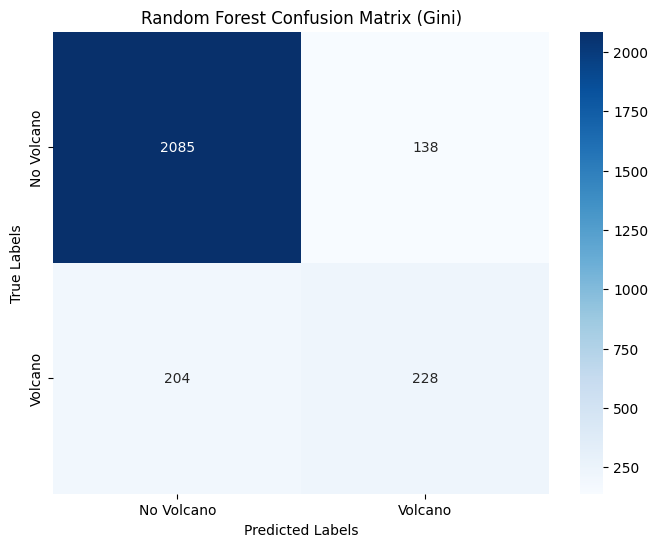

In [15]:
# Confusion matrix visualization referred to Gini criterion

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Volcano", "Volcano"], yticklabels=["No Volcano", "Volcano"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Random Forest Confusion Matrix (Gini)")
plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# IMPURITY MEASURE: ENTROPY
# Instantiate the model with 1000 trees and 'entropy' as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=1000, max_depth=None, criterion="entropy")
Random_Forest_model.fit(X_train_balanced, y_train_balanced)

predictions = Random_Forest_model.predict(X_test_reduced) # We use X_test_reduced because we applied PCA on X_test

# Print the classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, predictions, target_names=["No Volcano", "Volcano"]))

Classification Report on Test Set:
              precision    recall  f1-score   support

  No Volcano       0.92      0.92      0.92      2223
     Volcano       0.59      0.59      0.59       432

    accuracy                           0.87      2655
   macro avg       0.76      0.76      0.76      2655
weighted avg       0.87      0.87      0.87      2655



According to the `f1-score` for the `Volcano` class and the `macro avg`, the main metrics we are interested in for this analysis, because they are the most comprehensive, using `entropy` as a criterion gives us slightly better results.

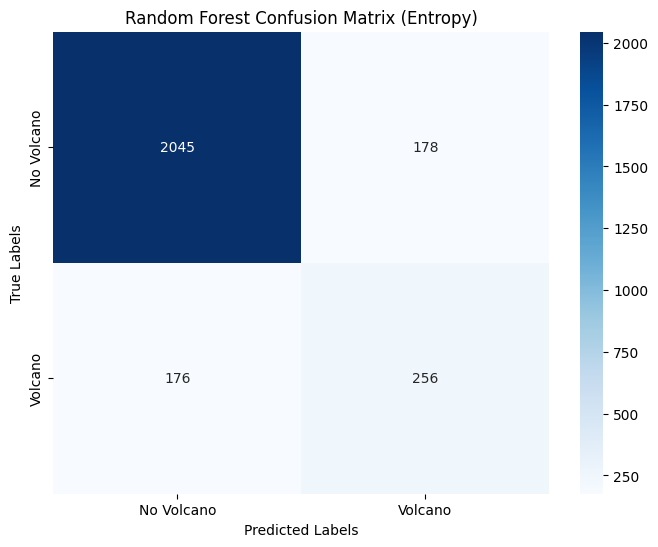

In [17]:
# Confusion matrix visualization referred to entropy criterion

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Volcano", "Volcano"], yticklabels=["No Volcano", "Volcano"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Random Forest Confusion Matrix (Entropy)")
plt.show()

Just to make sure we are not overfitting, given the almost absent regularization in the models (`n_estimators=1000`, `max_depth=None`). Let's analyze the performance of the model on the train data (we'll use `entropy` as impurity measure, because we showed its slightly better perfomance).

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# IMPURITY MEASURE: ENTROPY
# Instantiate the model with 1000 trees and 'entropy' as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=1000, max_depth=None, criterion="entropy")
Random_Forest_model.fit(X_train_balanced, y_train_balanced)

# Get predictions on train data
train_predictions = Random_Forest_model.predict(X_train_balanced)

# Get predictions on test data  
test_predictions = Random_Forest_model.predict(X_test_reduced) # We use X_test_reduced because we applied PCA on X_test

# Print the classification report for train data
print("Classification Report on Train Set:")
print(classification_report(y_train_balanced, train_predictions, target_names=["No Volcano", "Volcano"]))

# Print the classification report for test data
print("Classification Report on Test Set:")
print(classification_report(y_test, test_predictions, target_names=["No Volcano", "Volcano"]))

Classification Report on Train Set:
              precision    recall  f1-score   support

  No Volcano       1.00      1.00      1.00      5804
     Volcano       1.00      1.00      1.00      5804

    accuracy                           1.00     11608
   macro avg       1.00      1.00      1.00     11608
weighted avg       1.00      1.00      1.00     11608

Classification Report on Test Set:
              precision    recall  f1-score   support

  No Volcano       0.92      0.92      0.92      2223
     Volcano       0.60      0.60      0.60       432

    accuracy                           0.87      2655
   macro avg       0.76      0.76      0.76      2655
weighted avg       0.87      0.87      0.87      2655



## Addressing overfitting

The classification report suggests a potential risk of overfitting, indicated by the perfect predictions on the training data. To address this, we will apply regularization by reducing the maximum depth of the trees from `None` to `10`. Additionally, since the `entropy` criterion slightly outperformed `gini` as the impurity measure, we will focus on it for the updated model.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# IMPURITY MEASURE: ENTROPY
# Instantiate the model with 1000 trees and 'entropy' as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=1000, max_depth=10, criterion="entropy")
Random_Forest_model.fit(X_train_balanced, y_train_balanced)

# Get predictions on train data
train_predictions = Random_Forest_model.predict(X_train_balanced)

# Get predictions on test data  
test_predictions = Random_Forest_model.predict(X_test_reduced) # We use X_test_reduced because we applied PCA on X_test

# Print the classification report for train data
print("Classification Report on Train Set:")
print(classification_report(y_train_balanced, train_predictions, target_names=["No Volcano", "Volcano"]))

# Print the classification report for test data
print("Classification Report on Test Set:")
print(classification_report(y_test, test_predictions, target_names=["No Volcano", "Volcano"]))

Classification Report on Train Set:
              precision    recall  f1-score   support

  No Volcano       1.00      0.97      0.98      5804
     Volcano       0.97      1.00      0.98      5804

    accuracy                           0.98     11608
   macro avg       0.98      0.98      0.98     11608
weighted avg       0.98      0.98      0.98     11608

Classification Report on Test Set:
              precision    recall  f1-score   support

  No Volcano       0.93      0.85      0.89      2223
     Volcano       0.47      0.69      0.56       432

    accuracy                           0.82      2655
   macro avg       0.70      0.77      0.72      2655
weighted avg       0.86      0.82      0.83      2655



The below plot visualizes how different tree depths affect performance on the training and test datasets. It helps identify the point at which overfitting may begin to occur. We reduce the number of trees to $100$ for quicker computation.

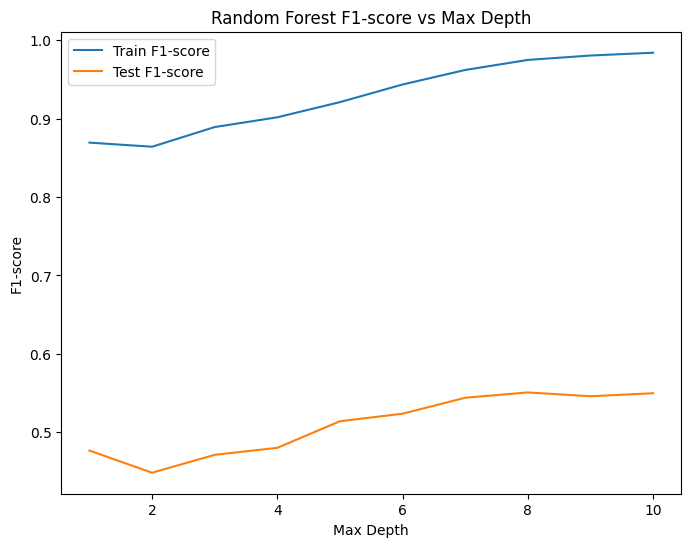

In [20]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

depths_list = list(range(1,11))

train_f1_scores_list = []
test_f1_scores_list = []

for depth in depths_list:
    rf = RandomForestClassifier(n_estimators=100, max_depth=depth, criterion="entropy")
    rf.fit(X_train_balanced, y_train_balanced)

    # Get predictions on train data
    train_predictions = rf.predict(X_train_balanced)
    # Compute F1-score for train data
    train_f1 = f1_score(y_train_balanced, train_predictions)
    train_f1_scores_list.append(train_f1)

    # Get predictions on test data  
    test_predictions = rf.predict(X_test_reduced) # We use X_test_reduced because we applied PCA on X_test
    # Compute F1-score for test data
    test_f1 = f1_score(y_test, test_predictions)
    test_f1_scores_list.append(test_f1)

# Plot the F1-scores
plt.figure(figsize=(8, 6))
plt.plot(depths_list, train_f1_scores_list, label='Train F1-score')
plt.plot(depths_list, test_f1_scores_list, label='Test F1-score')
plt.xlabel('Max Depth')
plt.ylabel('F1-score')
plt.title('Random Forest F1-score vs Max Depth')
plt.legend()

# Save the plot as a PDF
plt.savefig("random_forest_overfitting_visualization.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

For a more stable analysis of the F1-scores, we increase the max depth to $500$.

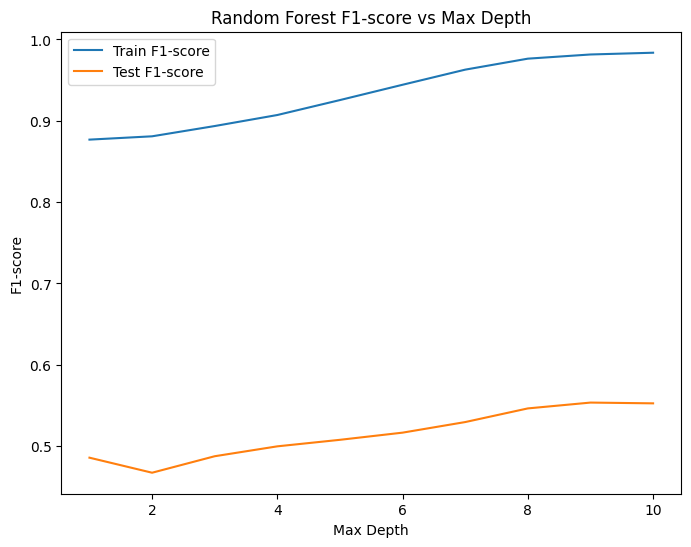

In [21]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

depths_list = list(range(1,11))

train_f1_scores_list = []
test_f1_scores_list = []

for depth in depths_list:
    rf = RandomForestClassifier(n_estimators=500, max_depth=depth, criterion="entropy")
    rf.fit(X_train_balanced, y_train_balanced)

    # Get predictions on train data
    train_predictions = rf.predict(X_train_balanced)
    # Compute F1-score for train data
    train_f1 = f1_score(y_train_balanced, train_predictions)
    train_f1_scores_list.append(train_f1)

    # Get predictions on test data  
    test_predictions = rf.predict(X_test_reduced) # We use X_test_reduced because we applied PCA on X_test
    # Compute F1-score for test data
    test_f1 = f1_score(y_test, test_predictions)
    test_f1_scores_list.append(test_f1)

# Plot the F1-scores
plt.figure(figsize=(8, 6))
plt.plot(depths_list, train_f1_scores_list, label='Train F1-score')
plt.plot(depths_list, test_f1_scores_list, label='Test F1-score')
plt.xlabel('Max Depth')
plt.ylabel('F1-score')
plt.title('Random Forest F1-score vs Max Depth')
plt.legend()

# Save the plot as a PDF
plt.savefig("random_forest_overfitting_visualization_500.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

### Cross-validation

We replicate the previous analysis, this time using cross-validation to ensure a more thorough and reliable evaluation. We start with `n_estimators=100`to reduce the computational time required.

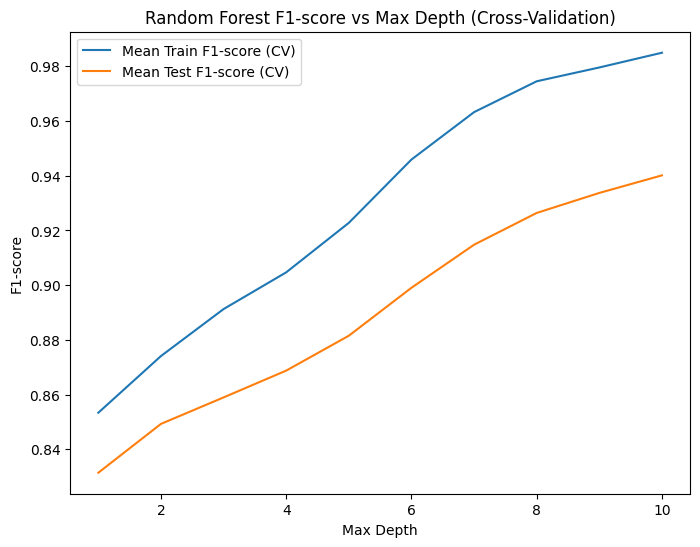

In [22]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of depths to evaluate
param_grid = {'max_depth': list(range(1, 11))}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=100, criterion="entropy", n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',
    cv=5,  # 5-fold cross-validation
    return_train_score=True  # Include training scores in results
)

# Perform GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Extract results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Plot the F1-scores
plt.figure(figsize=(8, 6))
plt.plot(param_grid['max_depth'], cv_results['mean_train_score'], label='Mean Train F1-score (CV)')
plt.plot(param_grid['max_depth'], cv_results['mean_test_score'], label='Mean Test F1-score (CV)')
plt.xlabel('Max Depth')
plt.ylabel('F1-score')
plt.title('Random Forest F1-score vs Max Depth (Cross-Validation)')
plt.legend()

# Save the plot as a PDF
plt.savefig("random_forest_cv_visualization.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

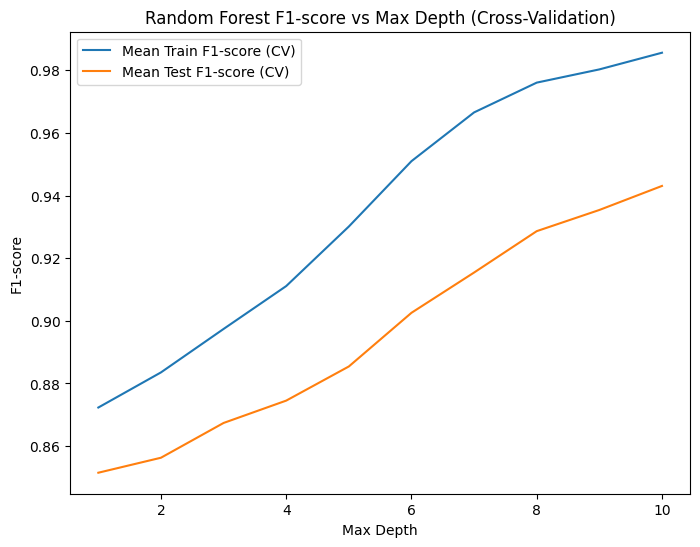

In [23]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of depths to evaluate
param_grid = {'max_depth': list(range(1, 11))}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',
    cv=5,  # 5-fold cross-validation
    return_train_score=True  # Include training scores in results
)

# Perform GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Extract results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Plot the F1-scores
plt.figure(figsize=(8, 6))
plt.plot(param_grid['max_depth'], cv_results['mean_train_score'], label='Mean Train F1-score (CV)')
plt.plot(param_grid['max_depth'], cv_results['mean_test_score'], label='Mean Test F1-score (CV)')
plt.xlabel('Max Depth')
plt.ylabel('F1-score')
plt.title('Random Forest F1-score vs Max Depth (Cross-Validation)')
plt.legend()

# Save the plot as a PDF
plt.savefig("random_forest_cv_visualization.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

c:\Users\lotop\OneDrive\Desktop\ml_uio_exercises\Machine-Learning-University-of-Oslo\Project3\ml_project3_env\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


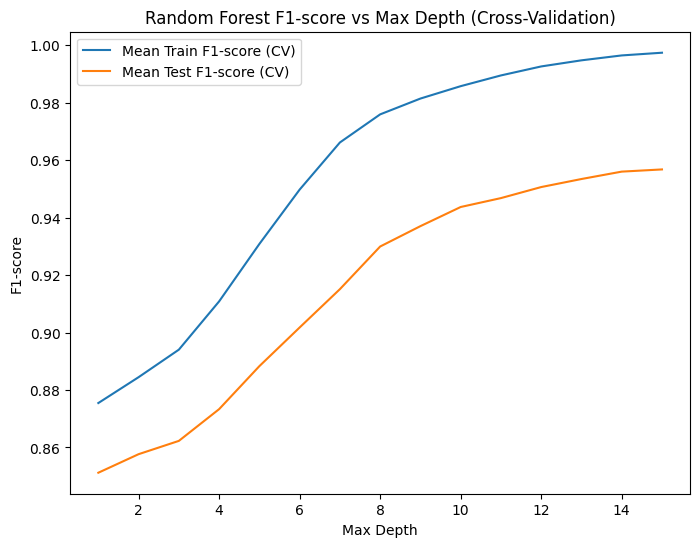

In [24]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of depths to evaluate
param_grid = {'max_depth': list(range(1, 16))}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',
    cv=5,  # 5-fold cross-validation
    return_train_score=True  # Include training scores in results
)

# Perform GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Extract results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Plot the F1-scores
plt.figure(figsize=(8, 6))
plt.plot(param_grid['max_depth'], cv_results['mean_train_score'], label='Mean Train F1-score (CV)')
plt.plot(param_grid['max_depth'], cv_results['mean_test_score'], label='Mean Test F1-score (CV)')
plt.xlabel('Max Depth')
plt.ylabel('F1-score')
plt.title('Random Forest F1-score vs Max Depth (Cross-Validation)')
plt.legend()

# Save the plot as a PDF
plt.savefig("random_forest_cv_visualization_15.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [28]:
print('Cross-validation results:')
print(cv_results[['param_max_depth', 'mean_train_score', 'mean_test_score']])

best_depth = grid_search.best_params_['max_depth']
print(f"Best max depth is: {best_depth}")

best_f1 = grid_search.best_score_
print(f"Best F1-score is: {best_f1:.4f}")

Cross-validation results:
    param_max_depth  mean_train_score  mean_test_score
0                 1          0.875469         0.851205
1                 2          0.884473         0.857661
2                 3          0.894054         0.862289
3                 4          0.910858         0.873339
4                 5          0.930857         0.888312
5                 6          0.949782         0.901772
6                 7          0.966190         0.915117
7                 8          0.975977         0.929967
8                 9          0.981484         0.937061
9                10          0.985797         0.943724
10               11          0.989537         0.946825
11               12          0.992667         0.950669
12               13          0.994794         0.953470
13               14          0.996502         0.956044
14               15          0.997444         0.956807
Best max depth is: 15
Best F1-score is: 0.9568


In [29]:
from sklearn.metrics import classification_report

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_reduced)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2223
           1       0.55      0.66      0.60       432

    accuracy                           0.86      2655
   macro avg       0.74      0.78      0.76      2655
weighted avg       0.87      0.86      0.86      2655



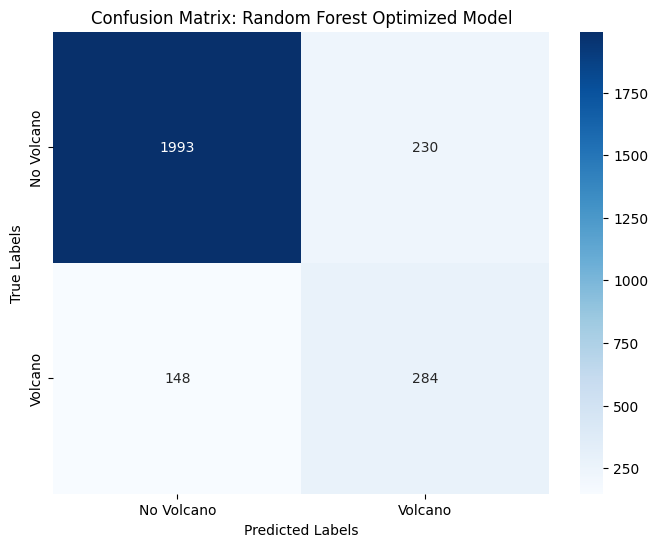

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for the Random Forest model
rf_cm = confusion_matrix(y_test, y_test_pred)  # Assuming y_test_pred are predictions from the best RF model

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Volcano", "Volcano"], yticklabels=["No Volcano", "Volcano"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix: Random Forest Optimized Model")

# Save the plot as a PDF
plt.savefig("confusion_matrix_random_forest_optimized.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()